In [3]:
# setwd("/projects/PPC/analysis/ppc_pilot/data/")

In [1]:
library(Seurat)
library(dplyr)
library(biomaRt)
library(stringr)
library(SCORPIUS)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
meta = read.csv("/projects/PPC/analysis/ppc_pilot/tables/ppc_pilot_metadata.csv")

In [3]:
temp_meta = data.frame(
                        udid = "Frazermerged_new",
                        name = "Frazermerged_new",
                        type = "All",
                        path = "/projects/PPC/pipeline/scRNA-Seq/ag_190708/ppc/outs/filtered_feature_bc_matrix/")

In [4]:
meta = rbind(meta,temp_meta)

In [5]:
sample_name = meta[meta$udid == "Frazermerged_new", "name"]
path        = meta[meta$udid == "Frazermerged_new", "path"]

# 1. QC Raw data (unfiltered)
iPSC + fresh PPC (aggr using CellRanger) integrated with frozen PPC (using Seurat IntegrateData)

NOTE, after integrating data, there are two assays: 

* You should use the 'integrated' assay when trying to 'align' cell states that are shared across datasets (i.e. for clustering, visualization, learning pseudotime, etc.)

* You should use the 'RNA' assay when exploring the genes that change either across clusters, trajectories, or conditions.

In [6]:
load("/projects/PPC/analysis/scrna_pilot/aggr_live_then_integrate/objects/obj.analyzed", verbose = T) # data intergated using seurat's integrate 

Loading objects:
  obj.analyzed


In [7]:
tiss = obj.analyzed

In [27]:
obj.analyzed = NULL

In [8]:
tiss

An object of class Seurat 
59820 features across 98474 samples within 2 assays 
Active assay: integrated (2000 features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [9]:
DefaultAssay(tiss) <- "RNA"

In [38]:
# tiss@meta.data$percent.mt_postInt <- PercentageFeatureSet(tiss, pattern = "^MT")

In [10]:
PlotQCMets <- function(){
    options(repr.plot.width = 8, repr.plot.height = 6)
    plot(tiss@meta.data$nCount_RNA, tiss@meta.data$percent.mt, pch = 20, cex = .5, xlab = "nUMI", ylab = "%MT", las = 1)
    abline(h = 10, col = "red")
    plot(tiss@meta.data$nCount_RNA, tiss@meta.data$nFeature_RNA, pch = 20, cex = .5, xlab = "nUMI", ylab = "n Unique Genes", las = 1)
    abline(h = 500, col = "red")
}

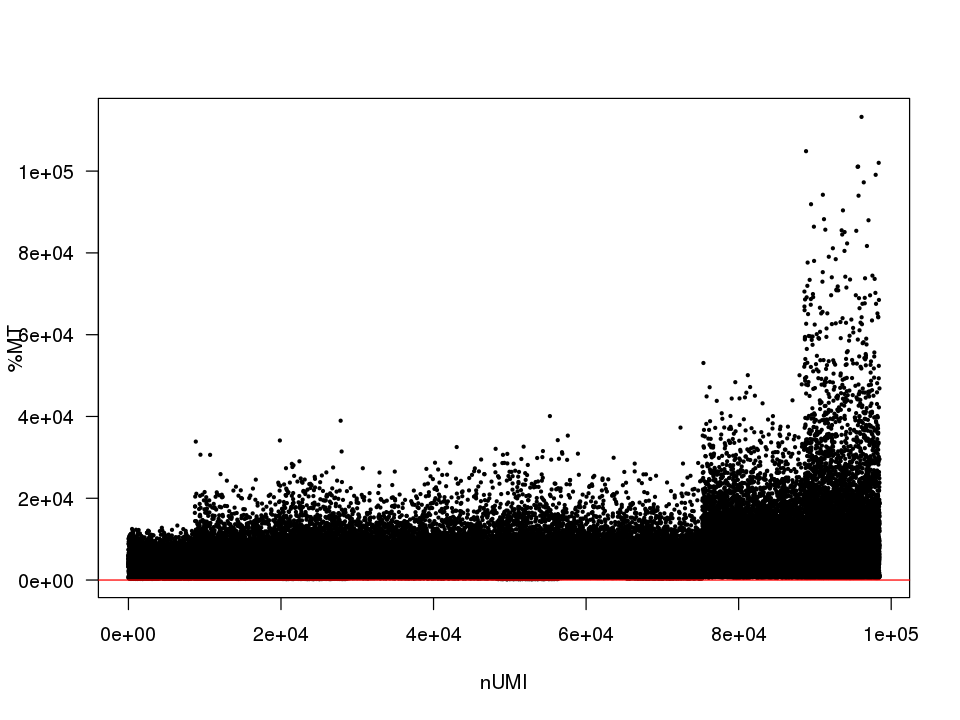

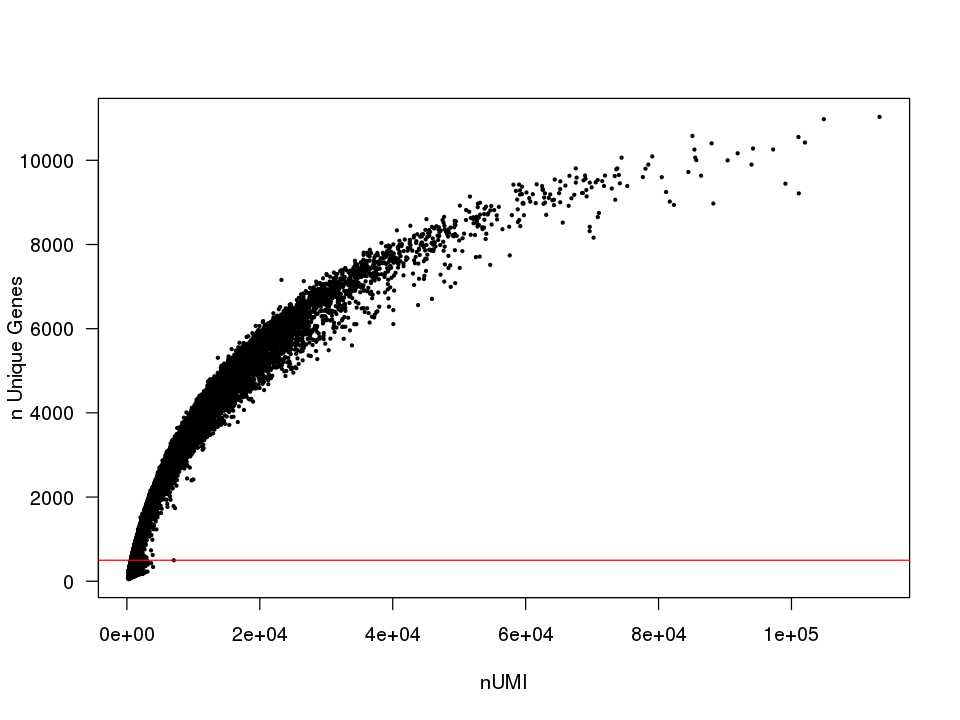

In [11]:
PlotQCMets()

## annotate cells with metadata (e.g. subject, batch, %MT, etc.)

In [12]:
tiss@meta.data$percent.mt_greater <- "MT < 10%"
tiss@meta.data[tiss@meta.data$percent.mt > 10, ]$percent.mt_greater <- "MT > 10%"

In [13]:
tiss@meta.data$nFeature_RNA_thresh <- "nGenes < 500"
tiss@meta.data[tiss@meta.data$nFeature_RNA > 500, ]$nFeature_RNA_thresh <- "nGenes > 500"

In [14]:
md = read.table("/projects/PPC/analysis/scrna_pilot/aggr_live_then_integrate/samples.txt", header = T)

In [15]:
# table(tiss@meta.data$label1)
table(tiss@meta.data$label2)


            C0005  C0005_PPC_PPC027             P0353             Q0115 
             3976              9646              3395              3897 
 Q0115_PPC_PPC023            S02307 S08401_PPC_PPC030              T104 
             9963              3377             10238              2337 
 T104_iPSC_PPC034   T104_PPC_PPC034              T151   T452_PPC_PPC028 
             8704             10965              3164              7864 
             T600   T600_PPC_PPC029   T600_PPC_PPC036 
             3108              8932              8908 

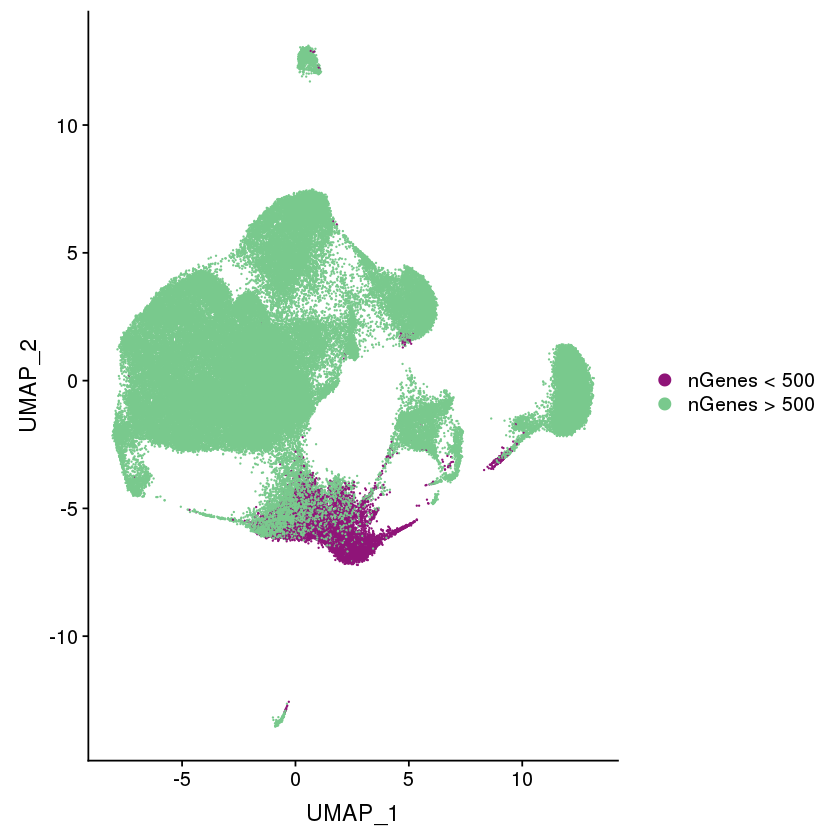

In [16]:
options(repr.plot.width = 7, repr.plot.height = 7)
DimPlot(tiss, group.by = "nFeature_RNA_thresh", cols = c("#8f1478", "#79c98d"))

In [80]:
# options(repr.plot.width = 7, repr.plot.height = 7)
# DimPlot(tiss, group.by = "percent.mt_greater", cols = c("#79c98d", "#8f1478"))

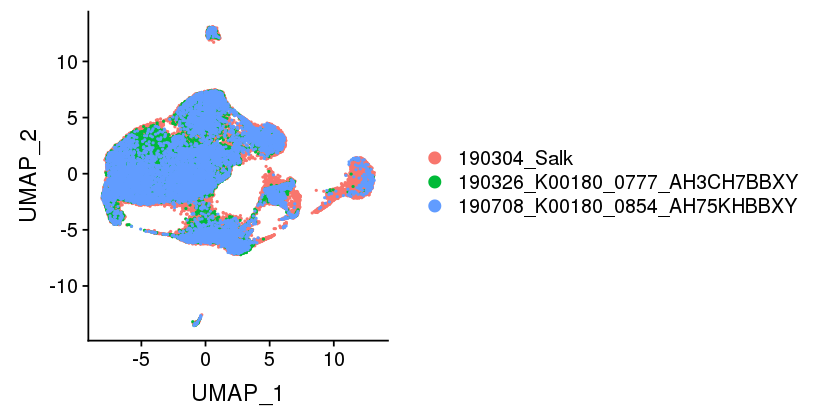

In [17]:
options(repr.plot.width = 7, repr.plot.height = 3.5)
DimPlot(tiss, pt.size = .25, label = F)

The following functions and any applicable methods accept the dots: CombinePlots


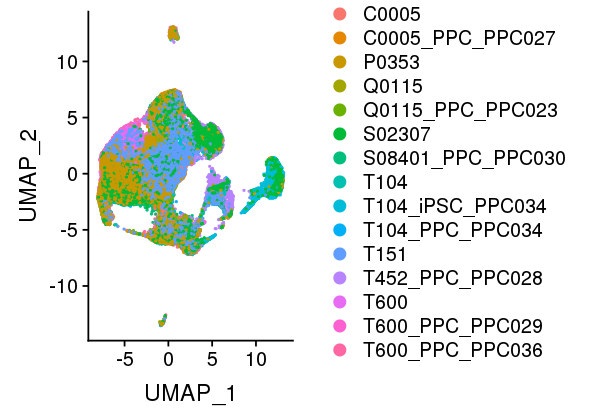

In [18]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
DimPlot(tiss, reduction.use = "umap", label = F, pt.size = .25, group.by = "label2")
#         , cols = c(mergedsamples$color[1:8], "#78022f", "#e30559", "#ba567c", "#fc9fc3", "#000875", "#1e4aeb", "#93a8f5")) #+ NoLegend() 


In [89]:
# out = "/projects/PPC/analysis/scrna_pilot/aggr_live_then_integrate/objects/"
# save(tiss,                   file = paste(out, "obj.analyzed.raw", sep = ""))

# 2. Filter Cells (<500 expressed genes)

In [19]:
DefaultAssay(tiss) <- "RNA"

In [20]:
tiss.filtered <- subset(tiss, subset = nFeature_RNA > 500)

In [ ]:
n.pcs = 20

tiss.filtered <- ScaleData(tiss.filtered)
tiss.filtered <- RunPCA(   tiss.filtered, npcs = (n.pcs + 5))
tiss.filtered <- RunUMAP(  tiss.filtered, dims = 1:n.pcs, min_dist = .8, seed = 10)


Centering and scaling data matrix


In [ ]:
res.used <- .5
tiss.filtered <- FindNeighbors(tiss.filtered, dims = 1:n.pcs)
tiss.filtered <- FindClusters( tiss.filtered, resolution = res.used)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
DimPlot(tiss.filtered, reduction.use = "umap", label = F, pt.size = .25, group.by = "label2")
DimPlot(tiss.filtered, reduction.use = "umap", label = T, pt.size = .25) + NoLegend()


# 3. Look at cell cycle

In [22]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

tiss.filtered <- CellCycleScoring(tiss.filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)

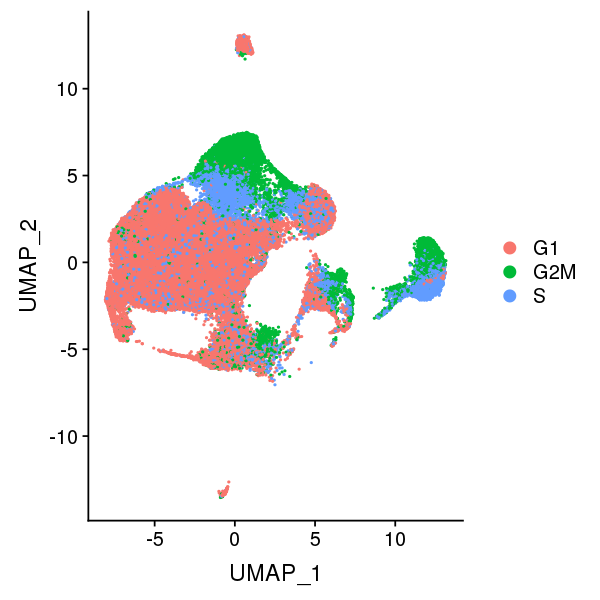

In [23]:
options(repr.plot.width = 5, repr.plot.height = 5)
DimPlot(tiss.filtered, group.by = "Phase", pt.size = .25) #+ NoLegend()

### regress out cc?? No.

In [2]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.analyzed.filtered", sep = "")
load(f, verbose = T)

Loading objects:
  tiss.filtered


In [7]:
DefaultAssay(tiss.filtered) <- "RNA"

In [ ]:
tiss.filtered_adjusted <- ScaleData(tiss.filtered, vars.to.regress = c("S.Score", "G2M.Score"))

Regressing out S.Score, G2M.Score


In [ ]:
tiss.filtered_adjusted <- RunPCA(tiss.filtered_adjusted, features = VariableFeatures(object = tiss.filtered_adjusted))

n.pcs = 20
res.used <- .5

tiss.filtered_adjusted <- FindNeighbors(tiss.filtered_adjusted, dims = 1:n.pcs)
tiss.filtered_adjusted <- FindClusters( tiss.filtered_adjusted, resolution = res.used)
tiss.filtered_adjusted <- RunUMAP(      tiss.filtered_adjusted, dims = 1:n.pcs, min_dist = .8, seed = 10)

# Sanity check: marker gene expression

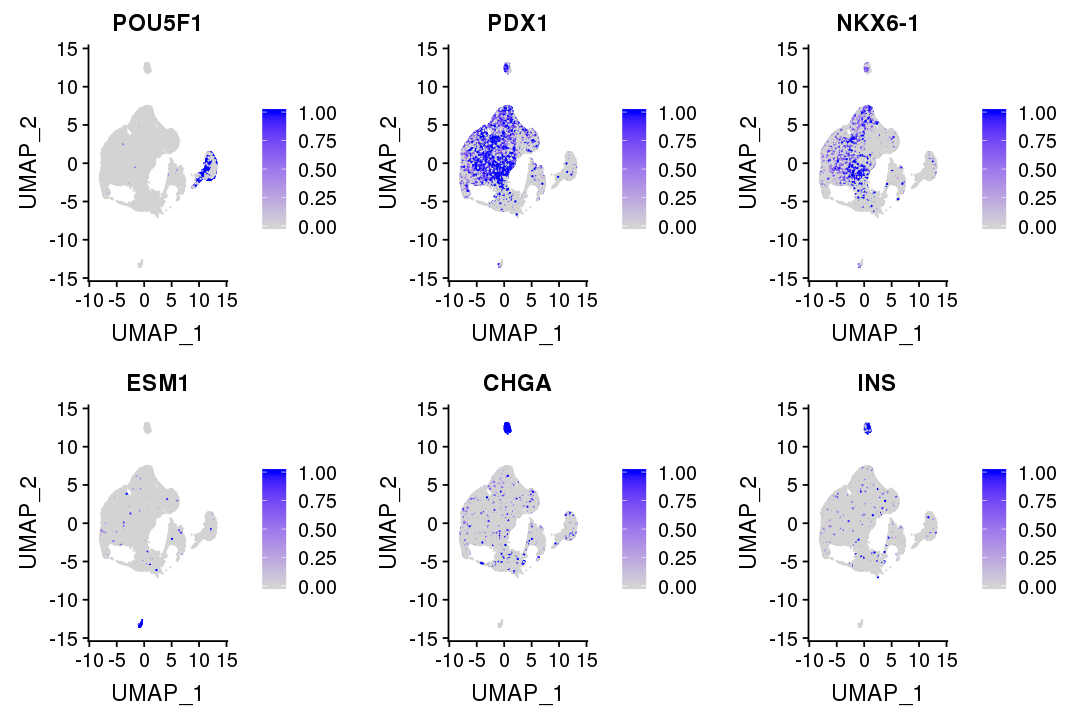

In [8]:
options(repr.plot.width = 9, repr.plot.height = 6)
FeaturePlot(tiss.filtered,
            c("POU5F1", "PDX1", "NKX6-1", "ESM1", "CHGA", "INS"),
            max.cutoff = 1, 
            ncol = 3)

In [24]:
totime = Embeddings(object = tiss.filtered, reduction = "pca")

space = reduce_dimensionality(as.matrix(totime), "spearman", ndim = 3)

traj = infer_trajectory(space)

cell2time = data.frame(cell = names(traj$time), time = as.numeric(traj$time))

In [37]:
exp = GetAssayData(object = tiss.filtered)

In [63]:
tiss.filtered@meta.data$cell = rownames(tiss.filtered@meta.data)

cell2time.new = merge(cell2time, tiss.filtered@meta.data, by = "cell")

In [64]:
genes = c("PDX1", "NKX6-1", "CHGA", "POU5F1")
genes.exp = as.data.frame(t(as.matrix(exp[genes, ])))
genes.exp$cell = rownames(genes.exp)

cell2time.new = merge(cell2time.new, genes.exp, by = "cell")
colnames(cell2time.new) = gsub("-", "_", colnames(cell2time.new))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


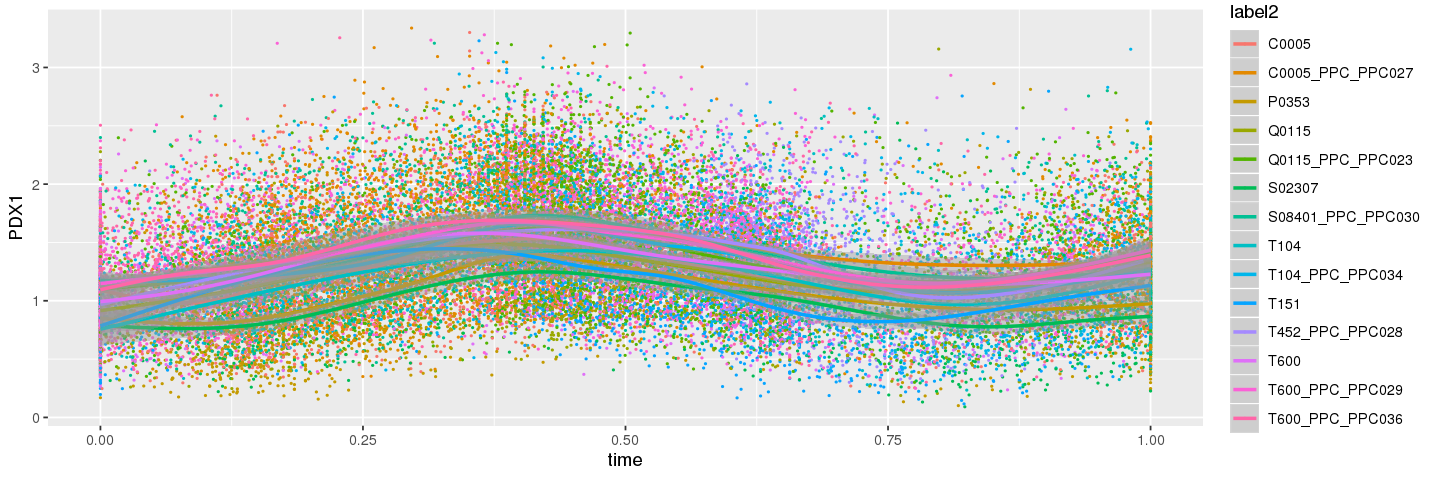

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


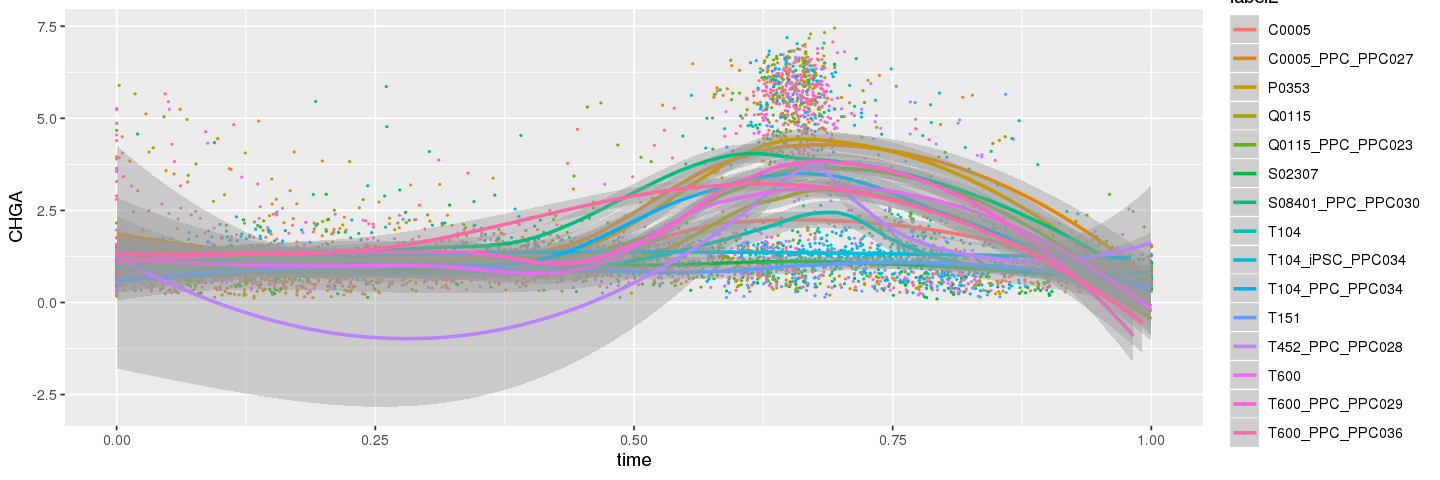

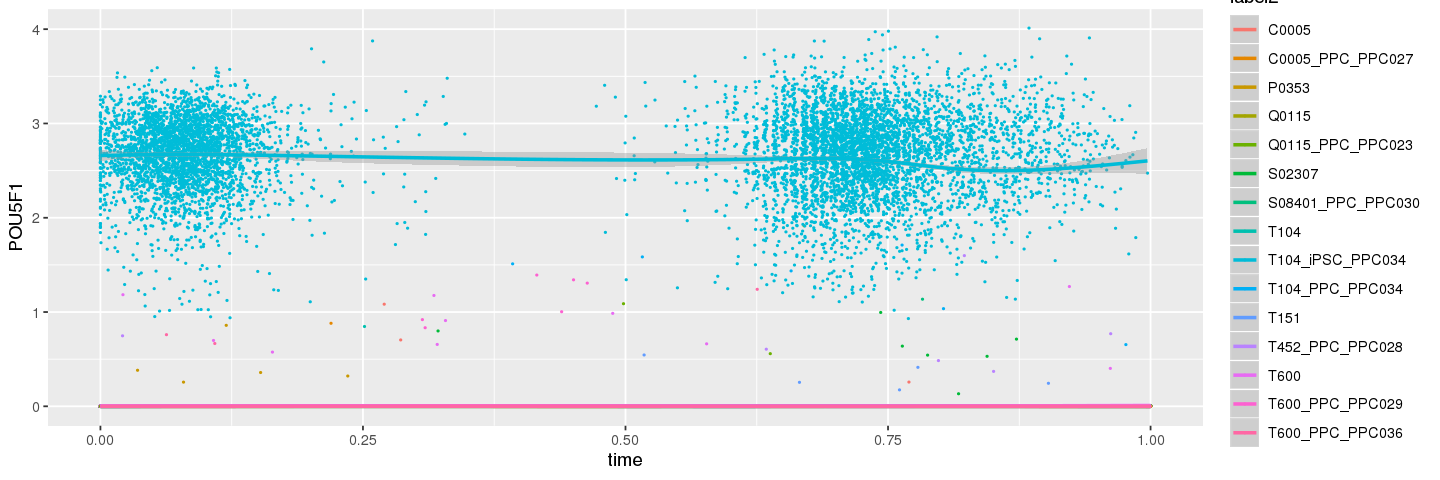

In [66]:
options(repr.plot.width = 12, repr.plot.height = 4)

ggplot(cell2time.new[!cell2time.new$label2 == "T104_iPSC_PPC034" & cell2time.new$PDX1 > 0, ], aes(x=time, y=PDX1, color=label2)) +
  geom_point(size=.25) +
  geom_smooth()


ggplot(cell2time.new[cell2time.new[,"CHGA"] > 0, ], aes(x=time, y=CHGA, color=label2)) +
  geom_point(size=.25) +
  geom_smooth()


ggplot(cell2time.new, aes(x=time, y=POU5F1, color=label2)) +
  geom_point(size=.25) +
  geom_smooth()

# Save robjs

In [25]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
save(tiss.filtered, file = paste(out, "obj.analyzed.filtered", sep = ""))